In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#read original files to get raw counts or genes for each sample
WT_10x_data = sc.read_10x_mtx('/Users/Yi/Desktop/Aire C311Y/Aire_WT_filtered_feature_bc_matrix')

In [3]:
C311Y_10x_data = sc.read_10x_mtx('/Users/Yi/Desktop/Aire C311Y/Aire_C311Y_het_filtered_feature_bc_matrix')

In [4]:
G228W_10x_data = sc.read_10x_mtx('/Users/Yi/Desktop/Aire C311Y/GW_Het_filtered_feature_bc_matrix')

In [5]:
#merge different samples
All_TSA = WT_10x_data. concatenate(C311Y_10x_data, G228W_10x_data)

In [6]:
#check the raw data to make sure we have all samples' raw data
All_TSA.obs.index

Index(['AAACCCAAGACATGCG-1-0', 'AAACCCAAGACCATGG-1-0', 'AAACCCAAGCTGTTCA-1-0',
       'AAACCCAAGGAACTCG-1-0', 'AAACCCAAGGCAGGGA-1-0', 'AAACCCACACAGCTGC-1-0',
       'AAACCCACACAGTCGC-1-0', 'AAACCCACACTATCCC-1-0', 'AAACCCACATCTCAAG-1-0',
       'AAACCCACATCTGTTT-1-0',
       ...
       'TTTGGTTTCTTAGGAC-1-2', 'TTTGGTTTCTTCGCTG-1-2', 'TTTGTTGCAGTGGCTC-1-2',
       'TTTGTTGCATGTTCAG-1-2', 'TTTGTTGGTCACGTGC-1-2', 'TTTGTTGTCAAGTTGC-1-2',
       'TTTGTTGTCAATCCGA-1-2', 'TTTGTTGTCATGTCAG-1-2', 'TTTGTTGTCGCGCCAA-1-2',
       'TTTGTTGTCGTTCCTG-1-2'],
      dtype='object', length=34789)

In [7]:
#read already processed data h5 files which already have identified clusters
TECs = sc.read('/Users/Yi/Desktop/Aire C311Y/TECs_wo_KO_wo_cell_cycle.h5ad')

In [8]:
#read the index of the processed data, you can see that there're less genes than the raw data
TECs.obs.index

Index(['AAACCCACACAGTCGC-1-0', 'AAACCCAGTAGTGTGG-1-0', 'AAACCCATCACTTTGT-1-0',
       'AAACGAATCTACTATC-1-0', 'AAACGCTAGTAAATGC-1-0', 'AAACGCTTCCCATGGG-1-0',
       'AAACGCTTCGCATTAG-1-0', 'AAAGAACAGAGTCAAT-1-0', 'AAAGGGCAGAGCAGCT-1-0',
       'AAAGGTATCGTAGGGA-1-0',
       ...
       'TTTCACATCAGAGCGA-1-2', 'TTTCAGTGTGTCGCTG-1-2', 'TTTCCTCCAGCGTATT-1-2',
       'TTTCGATAGCGCAATG-1-2', 'TTTCGATAGGAAAGGT-1-2', 'TTTCGATCAGGACAGT-1-2',
       'TTTCGATCATCTATCT-1-2', 'TTTCGATTCCAACTAG-1-2', 'TTTGACTTCCCAATAG-1-2',
       'TTTGGTTAGTGGTTGG-1-2'],
      dtype='object', name='index', length=3592)

In [9]:
#creat a copy raw data
raw=All_TSA[TECs.obs.index].copy()

In [10]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw,min_counts=0.1*raw.shape[0])
gene_list = np.array(raw.var_names)

In [11]:
#we first would like to make sure that Aire in the gene_list, if not, means something went wrong
'Aire' in gene_list.tolist()

True

In [12]:
#and then we looked at the details of raw data of the processed data
Nc,G,Nr,Nr_bar = sd.get_info(raw)

## Nc=3592, G=7373, Nr=5643.36, Nr_bar=0.77


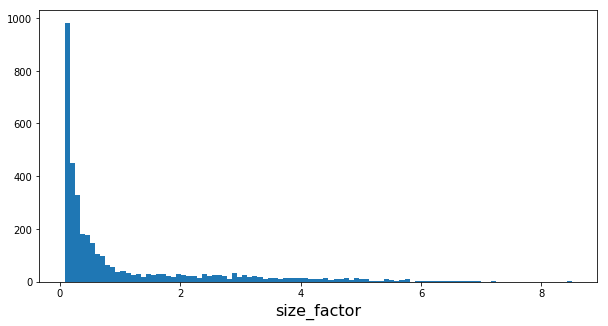

In [13]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [14]:
#run sceb 
M_ml, M_dd = sd.dd_1d_moment(raw, size_factor=size_factor)
cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=3592, n_gene=7373
#total: 0.09s


In [15]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=3592, n_gene=7373, Nr=5643.4
#total: 38.58s
#time start: 0.0s
n_cell=3592, n_gene=7373, Nr=5643.4
#total: 36.16s


In [17]:
import pandas as pd

In [18]:
#generate a dataframe for uncorrected correlation list using plug-in PC_ml 
#uncorrected_correlations=pd.DataFrame(PC_ml, index=gene_list.tolist(), columns=gene_list.tolist())

In [23]:
#and then we'd like to use PC_dd to get corrected correlated gene list for Aire
corrected_correlations=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [24]:
#a gene list with corrected correlated genes
corrected_correlations['Aire'].sort_values(ascending=False)

Aire             1.000000
3110043O21Rik    0.850708
Grin2c           0.824146
Snx8             0.823867
Rnaseh2b         0.779224
Wdr90            0.752221
Stra6            0.730991
Zfp771           0.726738
Hnf1a            0.716775
Lrrc42           0.708372
Caap1            0.703150
Kynu             0.691993
Icosl            0.665179
Dennd4a          0.648289
Tvp23a           0.645278
Hdc              0.642455
Nsmce1           0.618754
Pex10            0.616459
Katnal1          0.613315
Wdr31            0.601607
Sh3tc2           0.600908
Snhg6            0.592185
Ankrd33b         0.591392
Rab21            0.590878
Htr7             0.589604
S100a14          0.583756
H2-DMb2          0.579744
Pde1c            0.576753
Dleu7            0.566226
Rap1gap          0.565076
                   ...   
Ptbp3           -0.400086
Exoc6b          -0.400293
Klf3            -0.405103
Ulk1            -0.406241
Hcls1           -0.410118
Prrc2b          -0.411512
Tollip          -0.412570
Def6        

In [25]:
#focus on mTEC subsets only
mTEC = TECs[(TECs.obs.leiden == 'Mature_mTEC1')|(TECs.obs.leiden == 'Mature_mTEC2')]

In [26]:
#focus on WT in total TECs 
WT_TEC = TECs[TECs.obs.batch == '0']

In [27]:
#CY in TECs
CY_TEC = TECs[TECs.obs.batch == '1']

In [28]:
#GW in TECs
GW_TEC = TECs[TECs.obs.batch == '2']

In [29]:
#WT in mTECs
WT_mTEC= mTEC[mTEC.obs.batch == '0']

In [30]:
#CY in mTECs
CY_mTEC = mTEC[mTEC.obs.batch == '1']

In [31]:
#GW in mTECs
GW_mTEC = mTEC[mTEC.obs.batch == '2']

In [32]:
#look at the genes from mTEC only
mTEC.obs.index

Index(['AAACCCACACAGTCGC-1-0', 'AAACCCATCACTTTGT-1-0', 'AAACGAATCTACTATC-1-0',
       'AAAGGGCAGAGCAGCT-1-0', 'AAATGGAAGGTCGTAG-1-0', 'AACAAAGAGACTCTTG-1-0',
       'AACAAAGCATCTAACG-1-0', 'AACCACATCTCGGGAC-1-0', 'AACCATGCAGGAGGAG-1-0',
       'AACCATGTCTAGTACG-1-0',
       ...
       'TTGGATGCATTACTCT-1-2', 'TTGTTCACATAATCCG-1-2', 'TTGTTGTAGCTGACCC-1-2',
       'TTTAGTCCACGAAGAC-1-2', 'TTTATGCCAGATACTC-1-2', 'TTTCCTCCAGCGTATT-1-2',
       'TTTCGATCAGGACAGT-1-2', 'TTTCGATTCCAACTAG-1-2', 'TTTGACTTCCCAATAG-1-2',
       'TTTGGTTAGTGGTTGG-1-2'],
      dtype='object', name='index', length=1333)

In [33]:
WT_TEC.obs.index

Index(['AAACCCACACAGTCGC-1-0', 'AAACCCAGTAGTGTGG-1-0', 'AAACCCATCACTTTGT-1-0',
       'AAACGAATCTACTATC-1-0', 'AAACGCTAGTAAATGC-1-0', 'AAACGCTTCCCATGGG-1-0',
       'AAACGCTTCGCATTAG-1-0', 'AAAGAACAGAGTCAAT-1-0', 'AAAGGGCAGAGCAGCT-1-0',
       'AAAGGTATCGTAGGGA-1-0',
       ...
       'TTTCATGCAAAGCAAT-1-0', 'TTTCATGCATCTATCT-1-0', 'TTTCATGGTACACGCC-1-0',
       'TTTCCTCCATGTGACT-1-0', 'TTTCGATTCACTAGCA-1-0', 'TTTGACTAGGGAGGTG-1-0',
       'TTTGACTAGTCATCGT-1-0', 'TTTGATCCAAAGGTTA-1-0', 'TTTGGAGCAACTTGCA-1-0',
       'TTTGGTTGTTGCCGAC-1-0'],
      dtype='object', name='index', length=1663)

In [34]:
WT_mTEC.obs.index

Index(['AAACCCACACAGTCGC-1-0', 'AAACCCATCACTTTGT-1-0', 'AAACGAATCTACTATC-1-0',
       'AAAGGGCAGAGCAGCT-1-0', 'AAATGGAAGGTCGTAG-1-0', 'AACAAAGAGACTCTTG-1-0',
       'AACAAAGCATCTAACG-1-0', 'AACCACATCTCGGGAC-1-0', 'AACCATGCAGGAGGAG-1-0',
       'AACCATGTCTAGTACG-1-0',
       ...
       'TTGCATTTCCAACTAG-1-0', 'TTGCGTCTCTTAGTTC-1-0', 'TTGGGCGTCGGTCTAA-1-0',
       'TTGGTTTGTCTACACA-1-0', 'TTGTGTTTCCATCTAT-1-0', 'TTTATGCGTCTGTCAA-1-0',
       'TTTCACACATTCACAG-1-0', 'TTTCACATCTGGGCAC-1-0', 'TTTCATGCATCTATCT-1-0',
       'TTTGGTTGTTGCCGAC-1-0'],
      dtype='object', name='index', length=556)

In [35]:
CY_TEC.obs.index

Index(['AAACCCACATGGATCT-1-1', 'AAACCCAGTACGATGG-1-1', 'AAACCCAGTCTTCGAA-1-1',
       'AAACGCTCACCTGATA-1-1', 'AAAGAACGTGGAAATT-1-1', 'AAAGGATAGAATTGCA-1-1',
       'AAAGGATAGTTGAATG-1-1', 'AAAGGATGTGCAGTGA-1-1', 'AAAGGGCCACCGGCTA-1-1',
       'AAAGTGACAAATTGGA-1-1',
       ...
       'TTTCATGTCCGTCACT-1-1', 'TTTGACTAGCATGCGA-1-1', 'TTTGACTAGCTTCGTA-1-1',
       'TTTGACTAGTCTCGTA-1-1', 'TTTGACTGTTCAAGGG-1-1', 'TTTGACTTCCAGCAAT-1-1',
       'TTTGATCAGGCCCACT-1-1', 'TTTGATCGTGTGTCGC-1-1', 'TTTGATCTCCCATGGG-1-1',
       'TTTGGAGAGCCGATTT-1-1'],
      dtype='object', name='index', length=1376)

In [36]:
CY_mTEC.obs.index

Index(['AAACCCACATGGATCT-1-1', 'AAACGCTCACCTGATA-1-1', 'AAAGAACGTGGAAATT-1-1',
       'AAAGTGACAAATTGGA-1-1', 'AACAAAGTCACTTGGA-1-1', 'AACACACTCATTCGTT-1-1',
       'AACAGGGCAGGCCCTA-1-1', 'AACCAACAGCTCCATA-1-1', 'AACCCAACAACCGCCA-1-1',
       'AACCCAAGTTCGTAAC-1-1',
       ...
       'TTTACCATCCCATAGA-1-1', 'TTTACGTAGTAAATGC-1-1', 'TTTACGTTCTCCCATG-1-1',
       'TTTAGTCGTCTTTCAT-1-1', 'TTTCACAAGTGGTTCT-1-1', 'TTTCACATCTATTGTC-1-1',
       'TTTCATGAGATAGCAT-1-1', 'TTTCATGGTAATTAGG-1-1', 'TTTGACTAGCTTCGTA-1-1',
       'TTTGACTGTTCAAGGG-1-1'],
      dtype='object', name='index', length=503)

In [37]:
GW_TEC.obs.index

Index(['AAACCCATCTGGCCGA-1-2', 'AAACGAACATGAATAG-1-2', 'AAAGGATCATCAGCTA-1-2',
       'AAAGGGCAGAAAGTCT-1-2', 'AAAGTCCGTCGGTACC-1-2', 'AACAAAGAGCCGCACT-1-2',
       'AACAAGACAGTGACCC-1-2', 'AACACACAGACGACGT-1-2', 'AACACACAGCATCAAA-1-2',
       'AACCACAAGCGGCTCT-1-2',
       ...
       'TTTCACATCAGAGCGA-1-2', 'TTTCAGTGTGTCGCTG-1-2', 'TTTCCTCCAGCGTATT-1-2',
       'TTTCGATAGCGCAATG-1-2', 'TTTCGATAGGAAAGGT-1-2', 'TTTCGATCAGGACAGT-1-2',
       'TTTCGATCATCTATCT-1-2', 'TTTCGATTCCAACTAG-1-2', 'TTTGACTTCCCAATAG-1-2',
       'TTTGGTTAGTGGTTGG-1-2'],
      dtype='object', name='index', length=553)

In [38]:
GW_mTEC.obs.index

Index(['AAACGAACATGAATAG-1-2', 'AAAGGGCAGAAAGTCT-1-2', 'AACAAAGAGCCGCACT-1-2',
       'AACAAGACAGTGACCC-1-2', 'AACACACAGACGACGT-1-2', 'AACACACAGCATCAAA-1-2',
       'AACCATGTCACGGTCG-1-2', 'AAGAACAAGGCCATAG-1-2', 'AAGACTCCAGGCATTT-1-2',
       'AAGATAGTCTCATTGT-1-2',
       ...
       'TTGGATGCATTACTCT-1-2', 'TTGTTCACATAATCCG-1-2', 'TTGTTGTAGCTGACCC-1-2',
       'TTTAGTCCACGAAGAC-1-2', 'TTTATGCCAGATACTC-1-2', 'TTTCCTCCAGCGTATT-1-2',
       'TTTCGATCAGGACAGT-1-2', 'TTTCGATTCCAACTAG-1-2', 'TTTGACTTCCCAATAG-1-2',
       'TTTGGTTAGTGGTTGG-1-2'],
      dtype='object', name='index', length=274)

In [39]:
#look at raw genes from mTEC subsets
raw_mTEC=All_TSA[mTEC.obs.index].copy()

In [40]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_mTEC,min_counts=0.1*raw_mTEC.shape[0])
gene_list = np.array(raw_mTEC.var_names)

In [41]:
'Aire' in gene_list.tolist()

True

In [42]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_mTEC)

## Nc=1333, G=7300, Nr=6719.81, Nr_bar=0.92


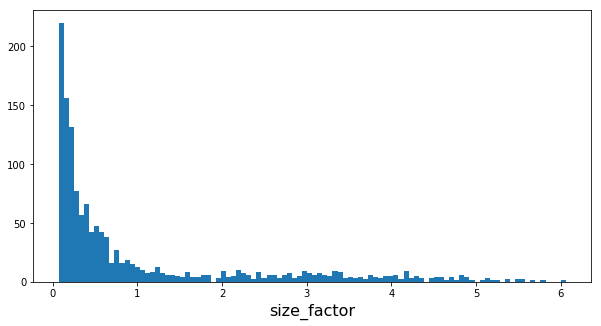

In [43]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_mTEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [44]:
M_ml, M_dd = sd.dd_1d_moment(raw_mTEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml) comparison for paper
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=1333, n_gene=7300
#total: 0.05s


In [45]:
# Estimate PC using plug-in (ml) not the right way for correlation
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_mTEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_mTEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=1333, n_gene=7300, Nr=6719.8
#total: 18.06s
#time start: 0.0s
n_cell=1333, n_gene=7300, Nr=6719.8
#total: 17.15s


In [46]:
#uncorrected_correlations_mTEC=pd.DataFrame(PC_ml, index=gene_list.tolist(), columns=gene_list.tolist())

In [48]:
corrected_correlations_mTEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [49]:
corrected_correlations_mTEC['Aire'].sort_values(ascending=False)

Aire             1.000000
3110043O21Rik    0.926205
Rasal2           0.842714
Snap91           0.819250
Chst11           0.815680
Arhgef3          0.788454
Grin2c           0.775191
Snx8             0.729703
Marveld2         0.708668
Atrn             0.696097
Kynu             0.694818
Tap1             0.672177
Stra6            0.668630
Zfp467           0.649370
Zfp771           0.649321
Wdr90            0.642350
Kctd15           0.636399
Dusp4            0.606001
Icosl            0.605662
Grem2            0.594246
Dennd4a          0.591478
Chst1            0.582883
Gm37233          0.573662
Nqo1             0.573018
Rac3             0.568538
Caap1            0.568407
Zcchc9           0.563300
Dhh              0.555439
Tnfrsf11a        0.553540
Lrrc42           0.549402
                   ...   
Anp32a          -0.511050
Chmp4b          -0.513298
D030056L22Rik   -0.515869
Phf2            -0.520652
Pcbp2           -0.522129
Mtx2            -0.523901
Cfl1            -0.533195
Trim8       

In [50]:
import seaborn as sns

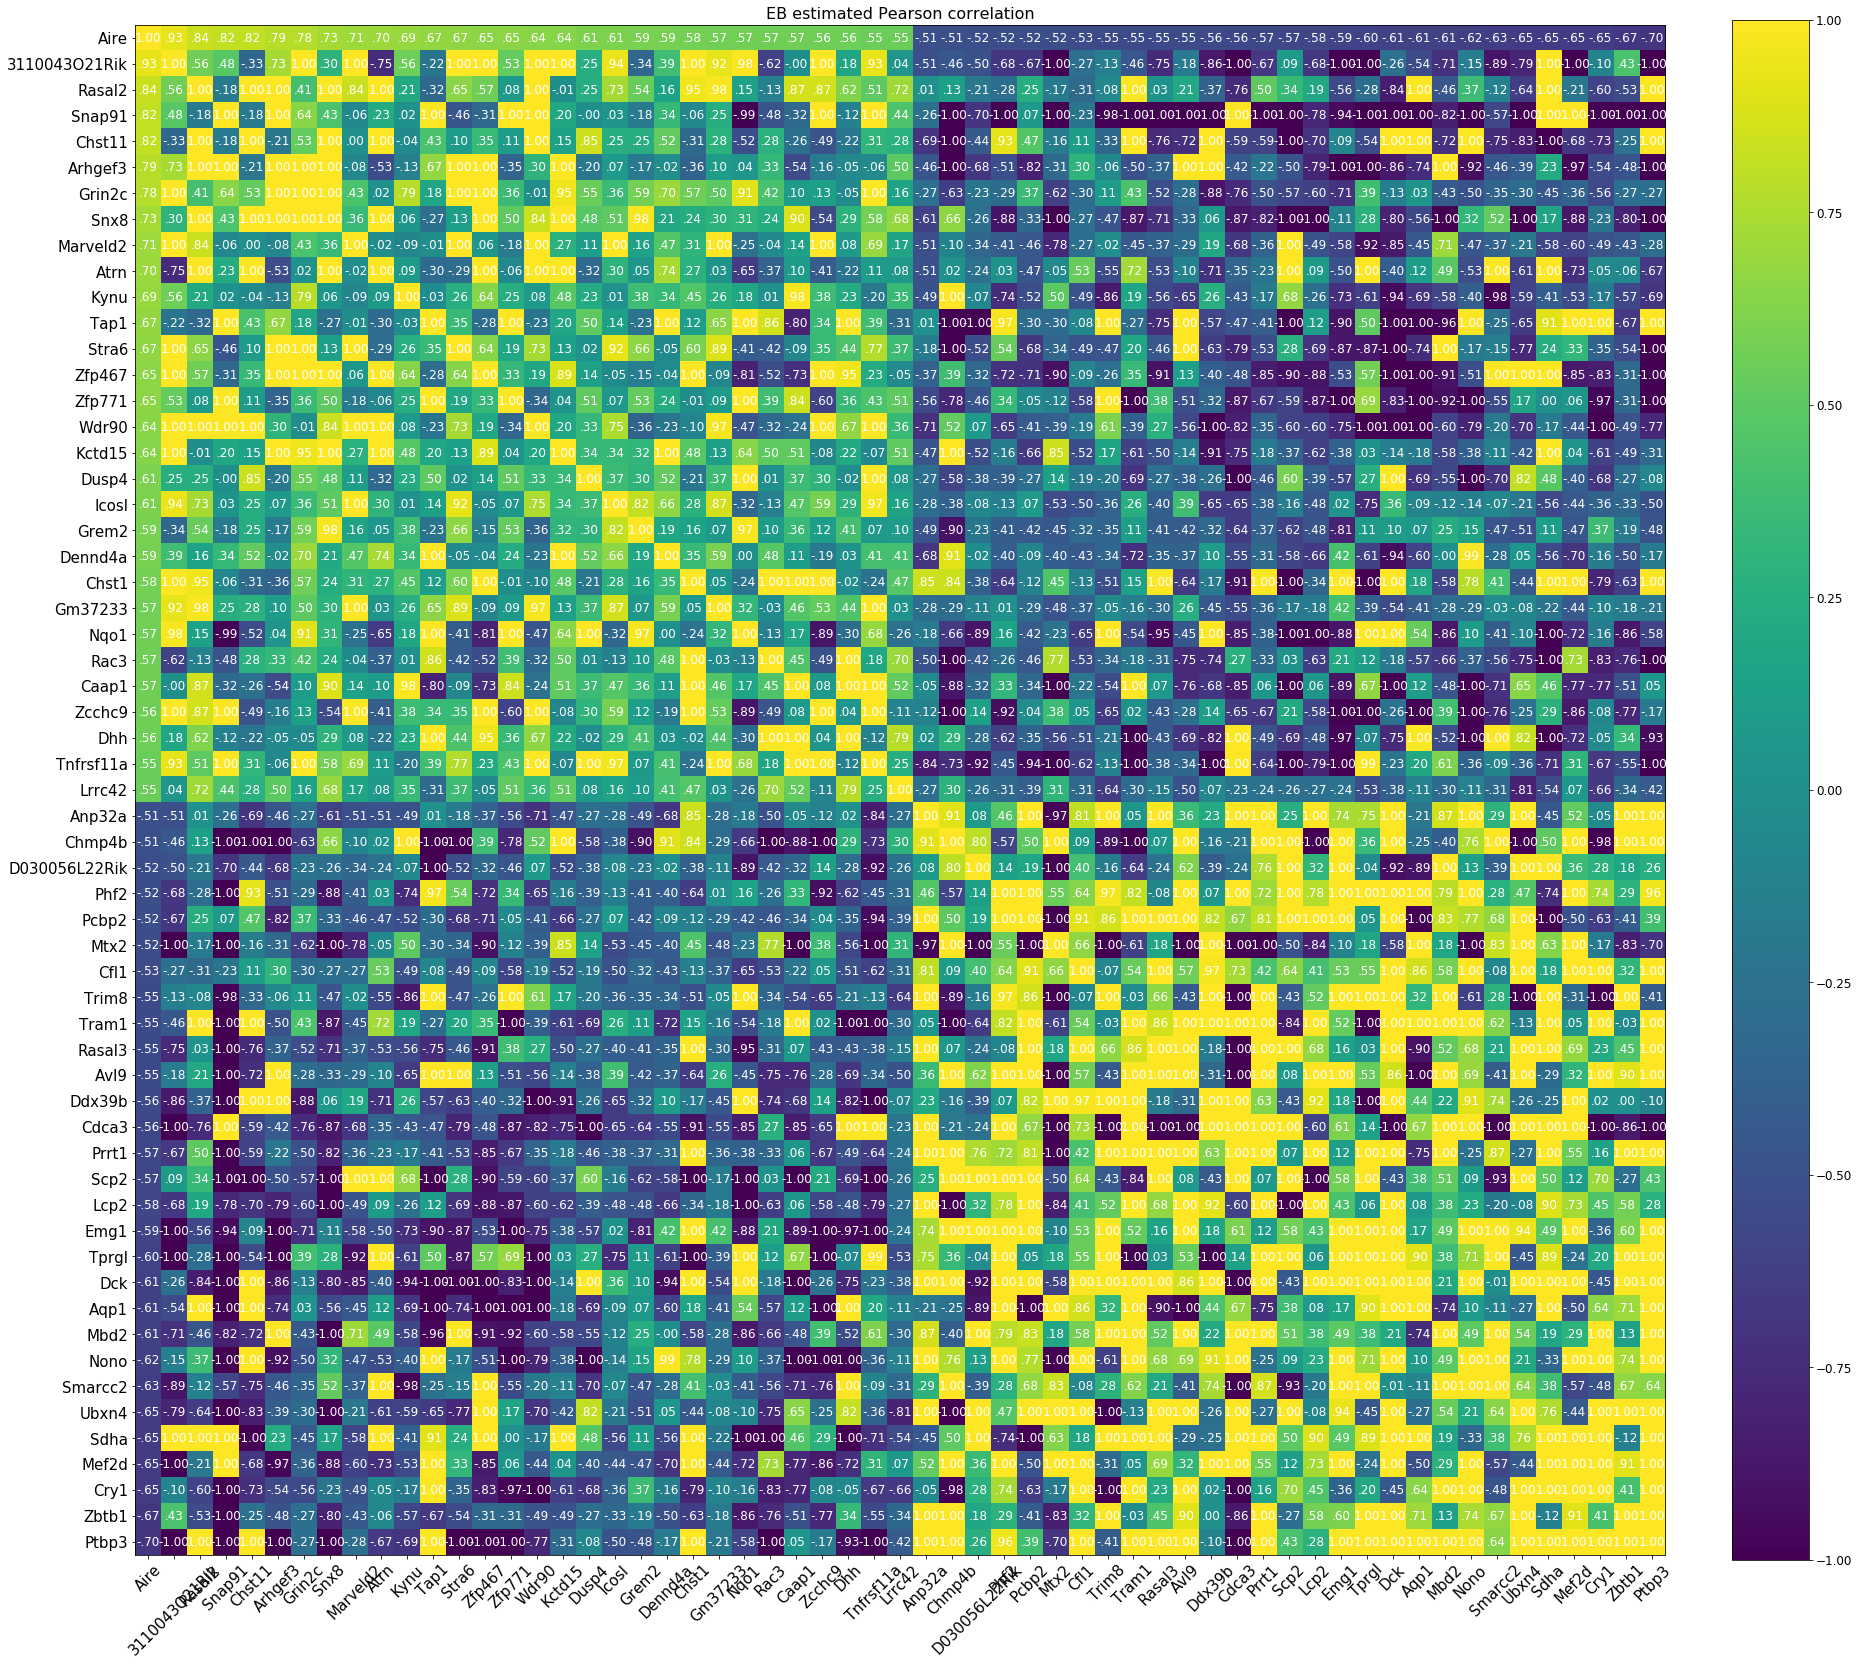

In [48]:
# Plot for # Plot for EB 
plt.figure(figsize=[30, 30])
sd.marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd)
plt.title('EB estimated Pearson correlation', fontsize=16)
plt.show()

In [51]:
#choose top25 gene from the gene list
top_25 = corrected_correlations['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_matrix = corrected_correlations[top_25].loc[top_25]


In [142]:
#choose random genes function:
np.random.permutation(10)

array([3, 2, 4, 7, 9, 6, 1, 8, 0, 5])

In [144]:
#get random genes from the EB correlation list
random_list=np.random.permutation(corrected_correlations.index)

In [161]:
#get top 100 genes from the random list
top=random_list.tolist()[:100]
top_matrix=corrected_correlations[top].loc[top]

In [153]:
#varify if the gene from the matrix showed up in this random list and its value
top_matrix.loc['Sp3']

Basp1       0.0
Vegfb       0.0
Rplp1       0.0
Thap2       0.0
Polr2c      0.0
Tox         0.0
Dpp8        0.0
Atp2a3      0.0
Pdzd2       0.0
Rasl10a     0.0
Sec11a      0.0
Tprkb       0.0
Neat1       0.0
Sp3         0.0
Nedd8       0.0
Smc6        0.0
Mob1b       0.0
Naca        0.0
Ankrd35     0.0
Il1f5       0.0
Ptprg       0.0
Gtpbp2      0.0
Mtch1       0.0
Chd3        0.0
Mrpl23      0.0
Zfp637      0.0
Ethe1       0.0
Dnaja2      0.0
Rab20       0.0
Zfp397      0.0
           ... 
Ubald2      0.0
Psat1       0.0
Bik         0.0
Chil4       0.0
Nrep        0.0
Mtmr3       0.0
Cul4a       0.0
Gss         0.0
Lcmt1       0.0
Uts2b       0.0
Erlec1      0.0
Gsta1       0.0
Il13        0.0
Cd80        0.0
Mboat1      0.0
Mgst1       0.0
Smc2        0.0
Abhd6       0.0
Cebpz       0.0
Mapk6       0.0
Blvra       0.0
Rars        0.0
Tor2a       0.0
Ssb         0.0
Gm15056     0.0
Ifngr1      0.0
Tspan31     0.0
Tpm3        0.0
Pkia        0.0
Sh3pxd2a    0.0
Name: Sp3, Length: 100, 

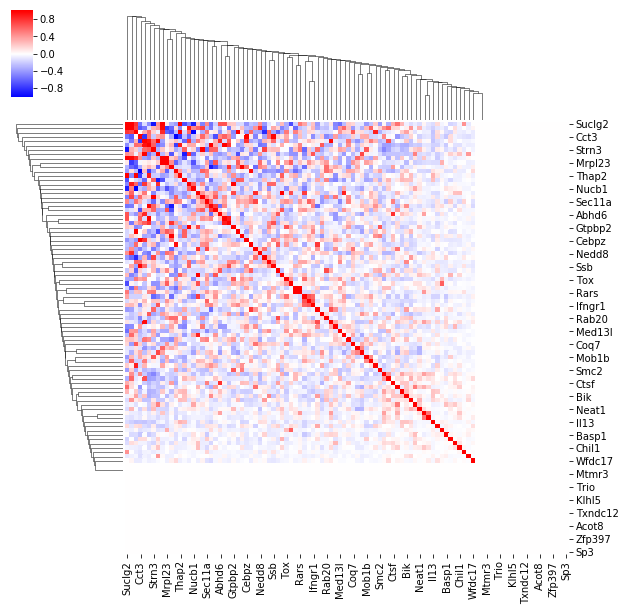

In [162]:
#cluster these random genes 
sns.clustermap(top_matrix,cmap='bwr')

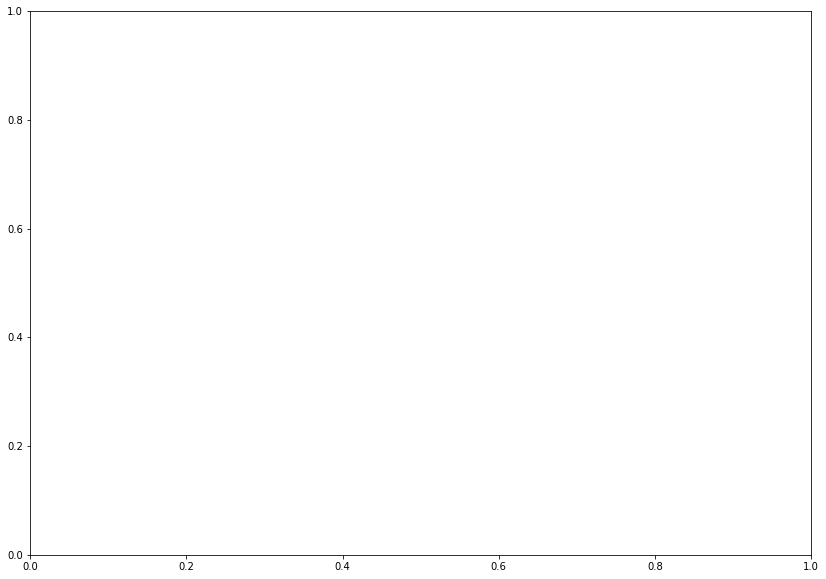

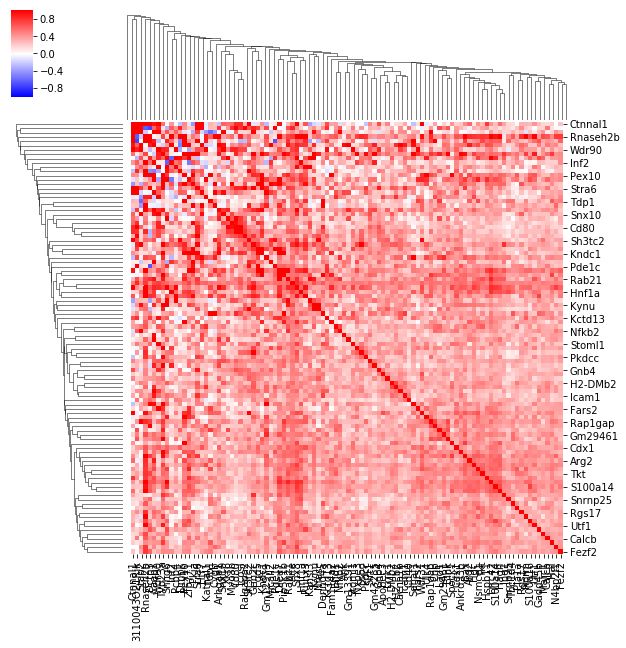

In [140]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.clustermap(top_100_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, square=True, xticklabels=True)

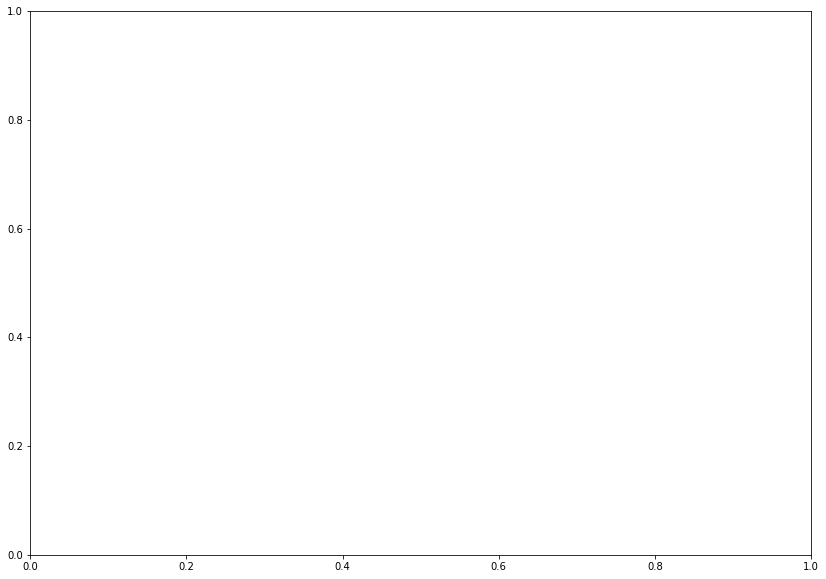

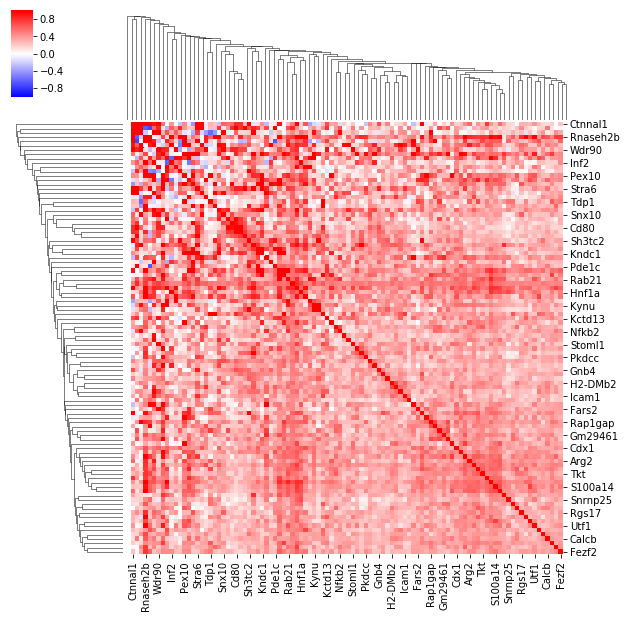

In [182]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.clustermap(top_100_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, square=True)

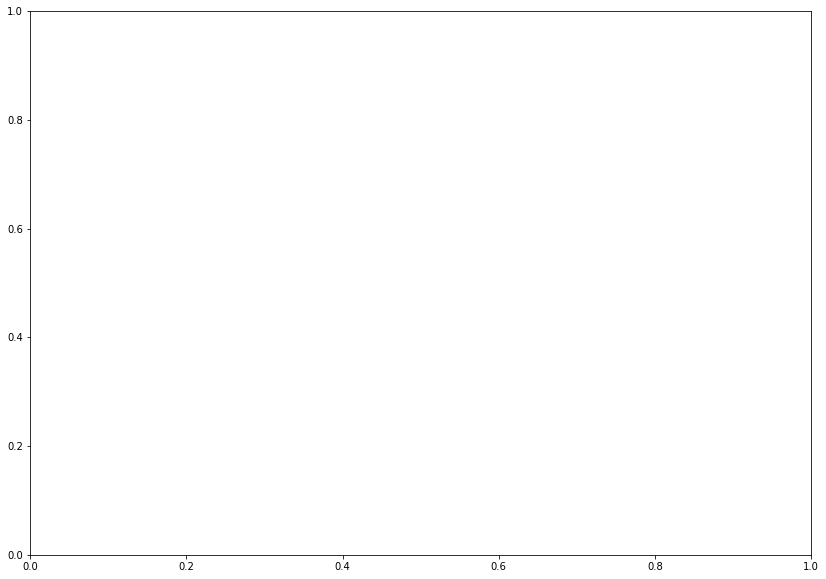

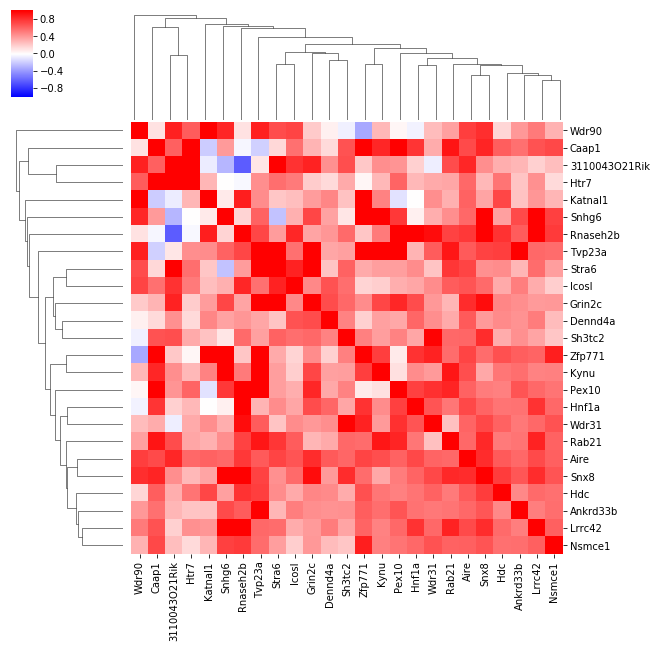

In [166]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.clustermap(top_25_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)

In [53]:
top_25_mTEC = corrected_correlations_mTEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_matrix_mTEC = corrected_correlations_mTEC[top_25].loc[top_25]


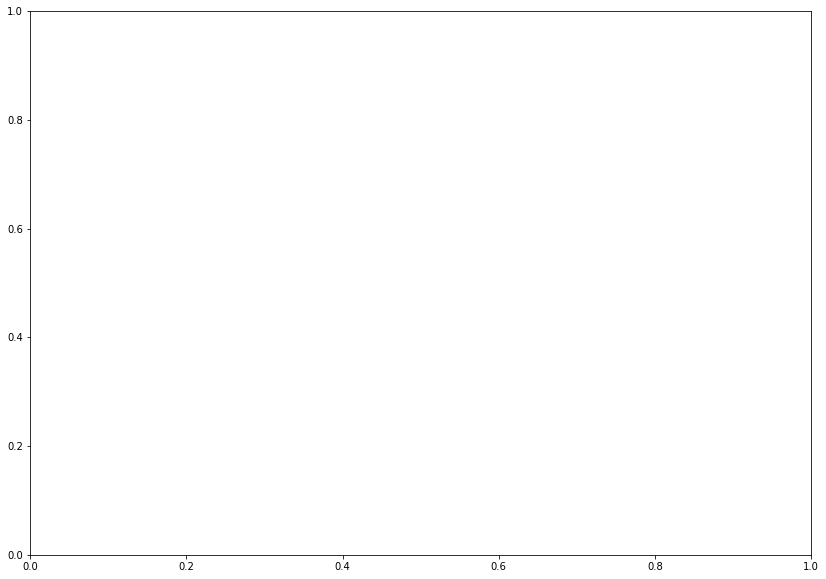

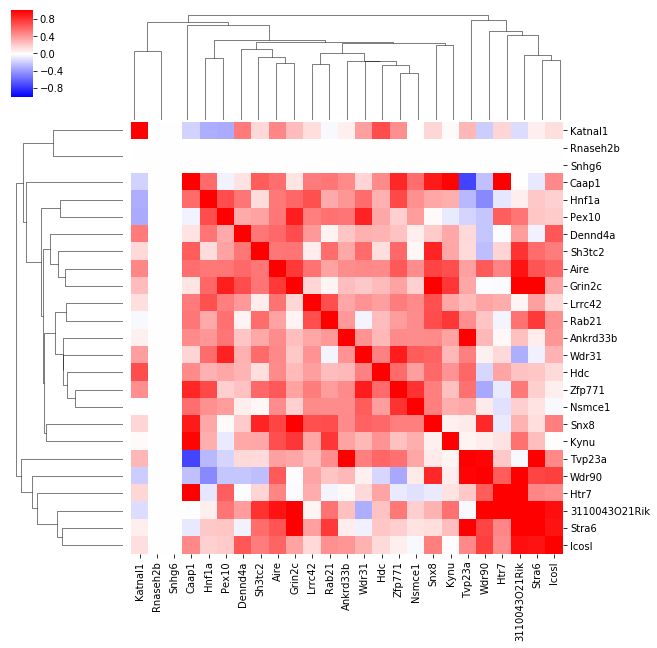

In [169]:
#TSAs: Arhgef3, Grin2c, Kynu, Tap1, Stra6, Zfp467, Icosl, Nqo1
fig, bx = plt.subplots()
fig.set_size_inches(14, 10)
bx=sns.clustermap(top_25_matrix_mTEC,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)

In [55]:
#look at raw genes from mTEC subsets
raw_WT_mTEC=All_TSA[WT_mTEC.obs.index].copy()

In [82]:
#look at raw genes from mTEC subsets
raw_CY_mTEC=All_TSA[CY_mTEC.obs.index].copy()

In [83]:
#look at raw genes from mTEC subsets
raw_GW_mTEC=All_TSA[GW_mTEC.obs.index].copy()

In [56]:
raw_WT_TEC=All_TSA[WT_TEC.obs.index].copy()

In [84]:
raw_CY_TEC=All_TSA[CY_TEC.obs.index].copy()

In [85]:
raw_GW_TEC=All_TSA[GW_TEC.obs.index].copy()

In [57]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_WT_TEC,min_counts=0.1*raw_WT_TEC.shape[0])
gene_list = np.array(raw_WT_TEC.var_names)

In [58]:
'Aire' in gene_list.tolist()

True

In [59]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_WT_TEC)

## Nc=1663, G=6931, Nr=4662.75, Nr_bar=0.67


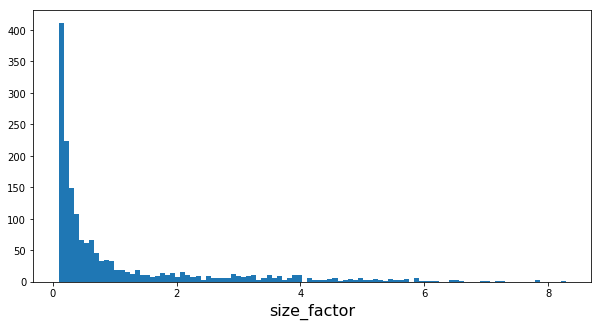

In [60]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_WT_TEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [61]:
M_ml, M_dd = sd.dd_1d_moment(raw_WT_TEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=1663, n_gene=6931
#total: 0.01s


In [62]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_WT_TEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_WT_TEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=1663, n_gene=6931, Nr=4662.8
#total: 16.03s
#time start: 0.0s
n_cell=1663, n_gene=6931, Nr=4662.8
#total: 20.83s


In [64]:
corrected_correlations_raw_WT_TEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [65]:
corrected_correlations_raw_WT_TEC['Aire'].sort_values(ascending=False)

Aire             1.000000
Icosl            0.918290
Grin2c           0.888821
Kynu             0.868995
Snhg6            0.798384
Hnf1a            0.782970
Stoml1           0.774025
3110043O21Rik    0.760824
Adgb             0.751356
Gramd4           0.718913
Lrrc42           0.685383
Runx3            0.682119
Rbpj             0.678843
Sspo             0.666879
Cnp              0.652758
Nsmce1           0.649793
Poglut1          0.644512
Fut8             0.644050
Nmrk1            0.622243
Ciita            0.616648
Stap2            0.614453
Nfasc            0.614249
Pip5k1b          0.612065
Pitpnc1          0.604098
Blnk             0.598414
Dleu7            0.586135
Ankrd33b         0.585402
Zc3h6            0.585249
Ing1             0.571502
Cdx1             0.569498
                   ...   
Cenpa           -0.400910
Anxa6           -0.401170
Tcf25           -0.405688
Mxd4            -0.406007
Abca1           -0.406184
Cfl1            -0.411262
Xrcc5           -0.411738
Dsc3        

In [77]:
top_25_corrected_correlations_raw_WT_TEC = corrected_correlations_raw_WT_TEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_corrected_correlations_raw_WT_TEC_matrix = corrected_correlations_raw_WT_TEC[top_25_corrected_correlations_raw_WT_TEC].loc[top_25_corrected_correlations_raw_WT_TEC]


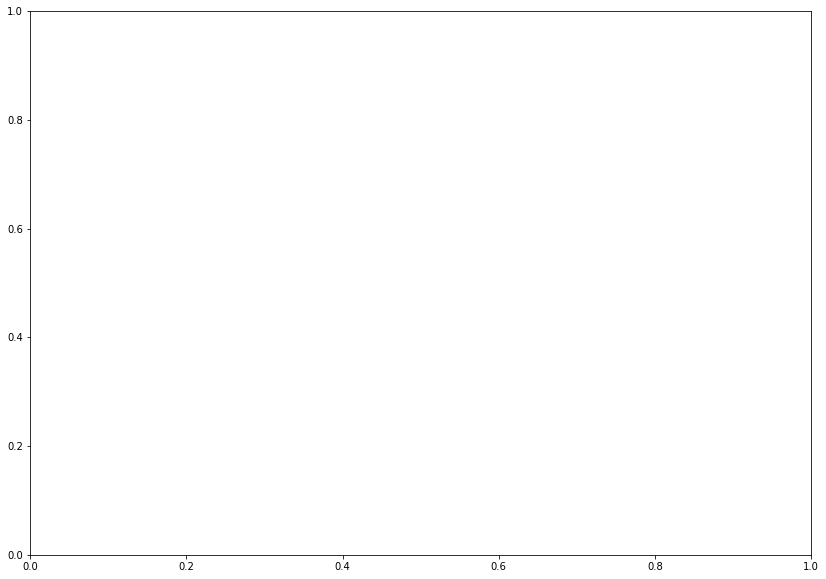

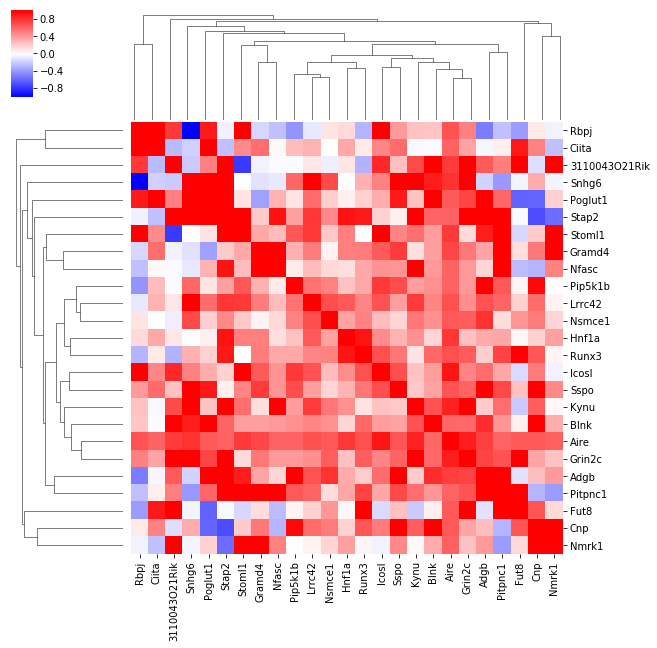

In [170]:
fig, cx = plt.subplots()
fig.set_size_inches(14, 10)
cx=sns.clustermap(top_25_corrected_correlations_raw_WT_TEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)


In [68]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_WT_mTEC,min_counts=0.1*raw_WT_mTEC.shape[0])
gene_list = np.array(raw_WT_mTEC.var_names)

In [69]:
'Aire' in gene_list.tolist()

True

In [70]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_WT_mTEC)

## Nc=556, G=6833, Nr=5184.52, Nr_bar=0.76


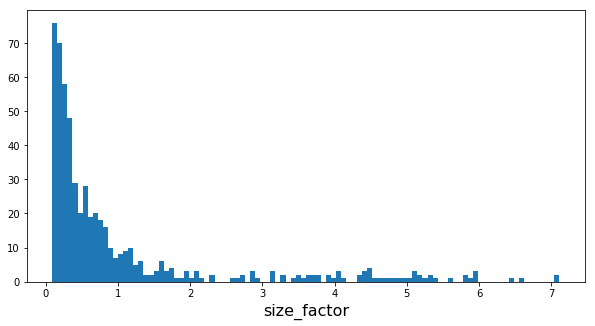

In [71]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_WT_mTEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [72]:
M_ml, M_dd = sd.dd_1d_moment(raw_WT_mTEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=556, n_gene=6833
#total: 0.07s


In [73]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_WT_mTEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_WT_mTEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=556, n_gene=6833, Nr=5184.5
#total: 8.32s
#time start: 0.0s
n_cell=556, n_gene=6833, Nr=5184.5
#total: 9.14s


In [75]:
corrected_correlations_raw_WT_mTEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [76]:
corrected_correlations_raw_WT_mTEC['Aire'].sort_values(ascending=False)

Lpgat1           1.000000
Aire             1.000000
Mars             0.995888
St5              0.981283
Ache             0.963102
Katnal1          0.923518
Icosl            0.917599
Tnfrsf11a        0.915075
Grin2c           0.903398
Stra6            0.880495
Kynu             0.871569
Nfasc            0.870672
Med13l           0.859558
Trip11           0.825153
Plce1            0.802974
Hivep1           0.799828
Wdr6             0.785138
Tbc1d8           0.785118
Rpf2             0.779725
Suclg2           0.762636
Lman1            0.759996
Gm37233          0.741409
Pkn2             0.734243
Nup88            0.731117
Slc18a1          0.718078
Pitpnc1          0.712872
Fut8             0.708185
Gramd4           0.704945
Ufsp1            0.704584
C77080           0.698337
                   ...   
Akap13          -0.521908
Gmds            -0.522323
Cry1            -0.526132
1110008F13Rik   -0.528486
Pecam1          -0.530179
Osgep           -0.534179
Trim35          -0.547381
Notch1      

In [80]:
top_25_corrected_correlations_raw_WT_mTEC = corrected_correlations_raw_WT_mTEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_corrected_correlations_raw_WT_mTEC_matrix = corrected_correlations_raw_WT_mTEC[top_25_corrected_correlations_raw_WT_mTEC].loc[top_25_corrected_correlations_raw_WT_mTEC]


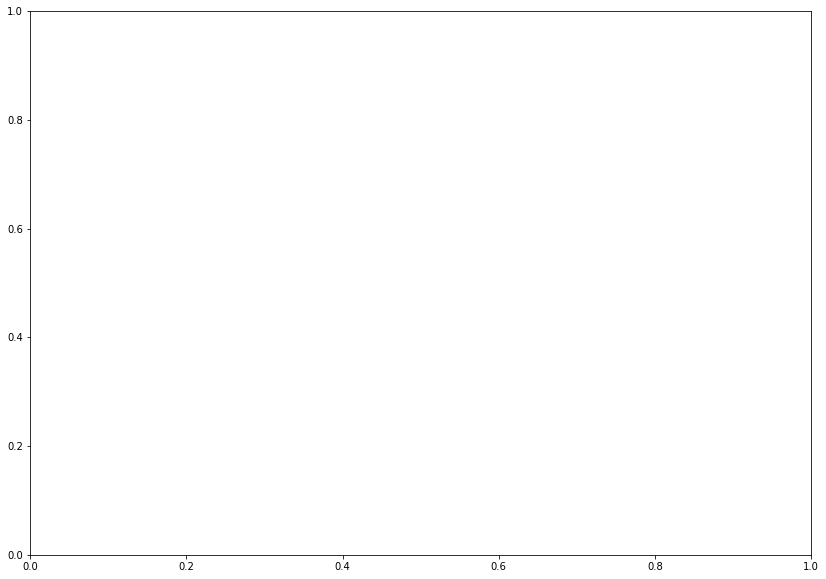

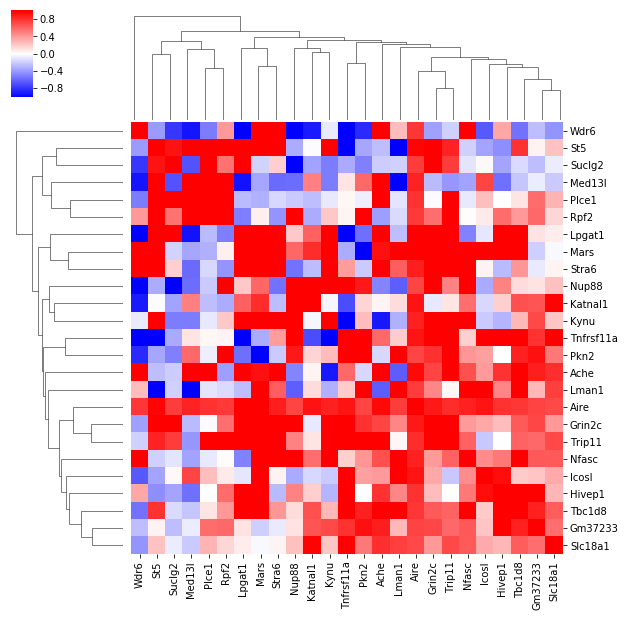

In [171]:
#TSA: Ache, Icosl, Tnfrsf11a, Grin2c, Stra6, Kynu, Nfasc, Plce1, Slc18a1
fig, cx = plt.subplots()
fig.set_size_inches(14, 10)
cx=sns.clustermap(top_25_corrected_correlations_raw_WT_mTEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)

In [86]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_CY_mTEC,min_counts=0.1*raw_CY_mTEC.shape[0])
gene_list = np.array(raw_CY_mTEC.var_names)

In [87]:
'Aire' in gene_list.tolist()

True

In [88]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_CY_mTEC)

## Nc=503, G=7275, Nr=7147.63, Nr_bar=0.98


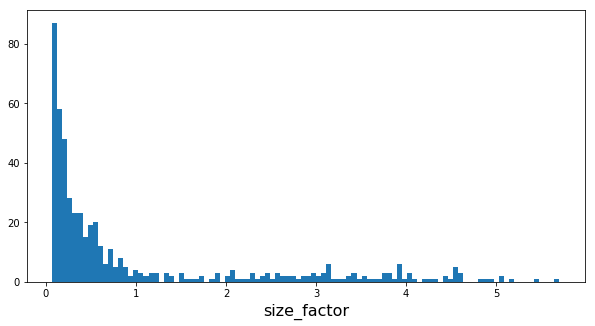

In [90]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_CY_mTEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [91]:
M_ml, M_dd = sd.dd_1d_moment(raw_CY_mTEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=503, n_gene=7275
#total: 0.04s


In [93]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_CY_mTEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_CY_mTEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=503, n_gene=7275, Nr=7147.6
#total: 11.31s
#time start: 0.0s
n_cell=503, n_gene=7275, Nr=7147.6
#total: 12.67s


In [95]:
corrected_correlations_raw_CY_mTEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [96]:
corrected_correlations_raw_CY_mTEC['Aire'].sort_values(ascending=False)

Sh3tc2           1.000000
Ptpn13           1.000000
Abi3bp           1.000000
D17Wsu92e        1.000000
Grin2c           1.000000
Ogdh             1.000000
Ddx23            1.000000
Arhgap44         1.000000
Ngdn             1.000000
Snx8             1.000000
Tead1            1.000000
Chst11           1.000000
Nt5c3b           1.000000
Lrrc45           1.000000
Aire             1.000000
Daam1            0.996835
D5Ertd579e       0.986005
Erbb2            0.966452
Tspan31          0.948174
Far1             0.940548
Gapvd1           0.936574
Klhdc8b          0.924947
5031439G07Rik    0.921834
Ube2z            0.906245
Acp2             0.898505
AU022252         0.878222
Dennd4a          0.858057
Rnft1            0.857334
Clptm1           0.846923
Fut1             0.844414
                   ...   
Slc1a5          -0.775246
March7          -0.776457
Pcbp2           -0.776774
Stard10         -0.777187
Ppp1r18         -0.778272
Trmt112         -0.778803
Atf7ip          -0.791540
Ndufb10     

In [97]:
top_25_corrected_correlations_raw_CY_mTEC = corrected_correlations_raw_CY_mTEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_corrected_correlations_raw_CY_mTEC_matrix = corrected_correlations_raw_CY_mTEC[top_25_corrected_correlations_raw_CY_mTEC].loc[top_25_corrected_correlations_raw_CY_mTEC]


In [154]:
random_list_CY=np.random.permutation(corrected_correlations_raw_CY_mTEC.index)

In [180]:
top_CY = random_list_CY.tolist()[:100]
top_CY_mTEC_matrix = corrected_correlations_raw_CY_mTEC[top_CY].loc[top_CY]


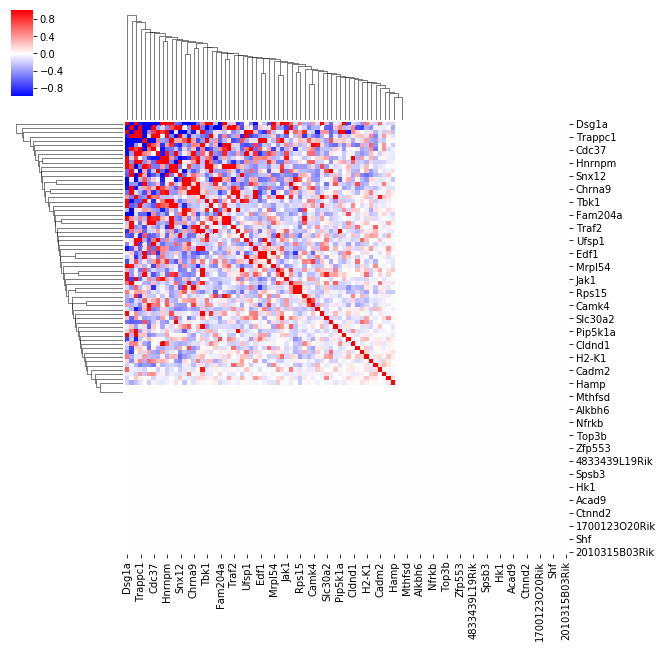

In [181]:
sns.clustermap(top_CY_mTEC_matrix,cmap='bwr')


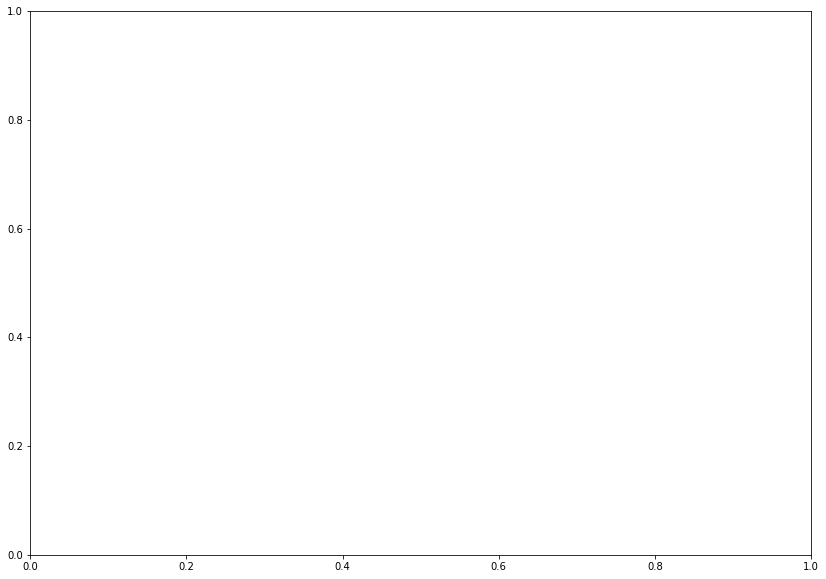

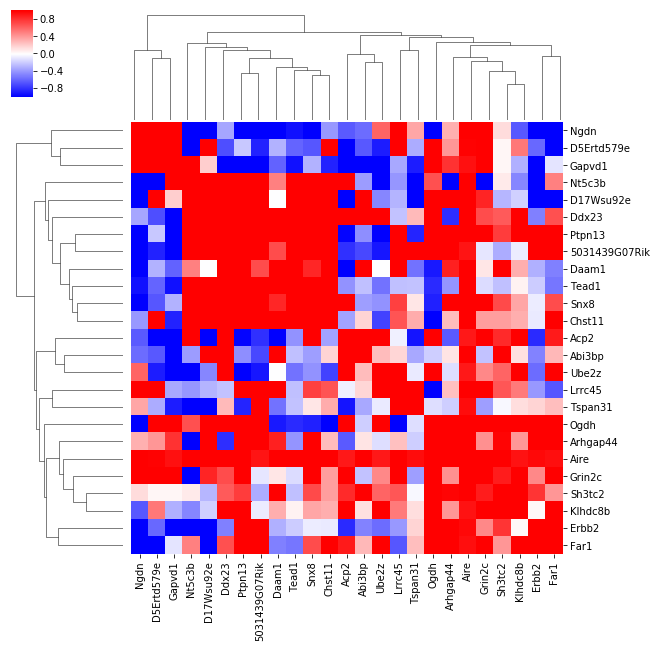

In [173]:
#TSA: Grin2c, Klhdc8b
fig, dx = plt.subplots()
fig.set_size_inches(14, 10)
dx=sns.clustermap(top_25_corrected_correlations_raw_CY_mTEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)


In [100]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_CY_TEC,min_counts=0.1*raw_CY_TEC.shape[0])
gene_list = np.array(raw_CY_TEC.var_names)

In [101]:
'Aire' in gene_list.tolist()

True

In [102]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_CY_TEC)

## Nc=1376, G=7268, Nr=5703.41, Nr_bar=0.78


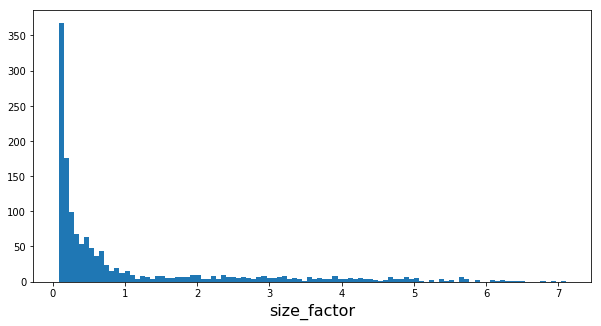

In [103]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_CY_TEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [104]:
M_ml, M_dd = sd.dd_1d_moment(raw_CY_TEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=1376, n_gene=7268
#total: 0.11s


In [105]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_CY_TEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_CY_TEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=1376, n_gene=7268, Nr=5703.4
#total: 16.81s
#time start: 0.0s
n_cell=1376, n_gene=7268, Nr=5703.4
#total: 18.48s


In [107]:
corrected_correlations_raw_CY_TEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [108]:
corrected_correlations_raw_CY_TEC['Aire'].sort_values(ascending=False)

Snx8             1.000000
Grin2c           1.000000
Sh3tc2           1.000000
Aire             1.000000
Nfkbie           0.961204
Relb             0.917606
Zfp771           0.854471
Adap1            0.822774
Tnip1            0.813725
5930412G12Rik    0.799866
Fgd5             0.784072
Kynu             0.775677
Runx3            0.758528
Mrpl11           0.754611
Irf5             0.754424
Dennd4a          0.751339
Nfasc            0.743345
Sirt1            0.717368
Fut1             0.707509
Cacna1b          0.697833
Chst11           0.689744
Acat1            0.689346
Hdc              0.686335
Lrat             0.682916
S100a14          0.675294
Nxpe3            0.668553
Lrrc42           0.665361
Ulk4             0.662840
H2-DMb2          0.661762
Hnf1a            0.658829
                   ...   
Trip12          -0.490973
Ube2r2          -0.493055
Tbc1d10c        -0.496460
Scnn1a          -0.498704
Prkcq           -0.503395
Rnf145          -0.503804
Ndufa5          -0.506569
Ptp4a1      

In [109]:
top_25_corrected_correlations_raw_CY_TEC = corrected_correlations_raw_CY_TEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_corrected_correlations_raw_CY_TEC_matrix = corrected_correlations_raw_CY_TEC[top_25_corrected_correlations_raw_CY_TEC].loc[top_25_corrected_correlations_raw_CY_TEC]


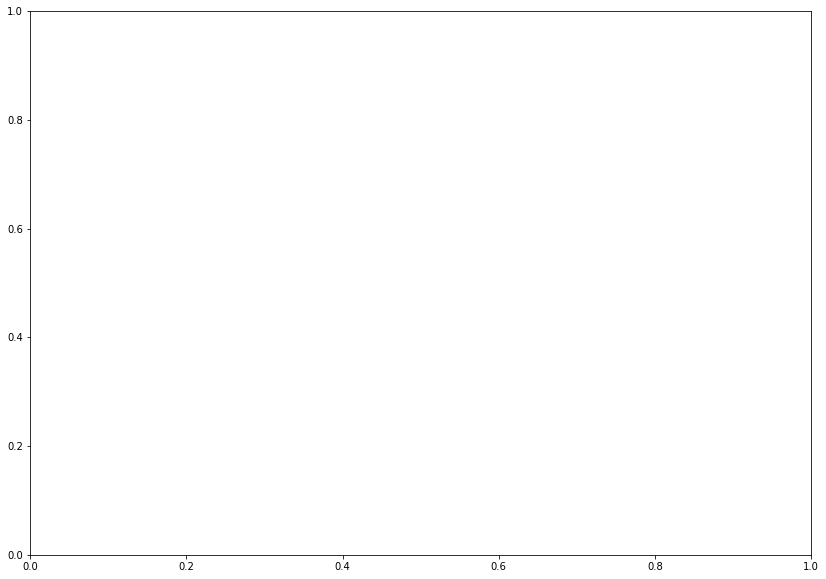

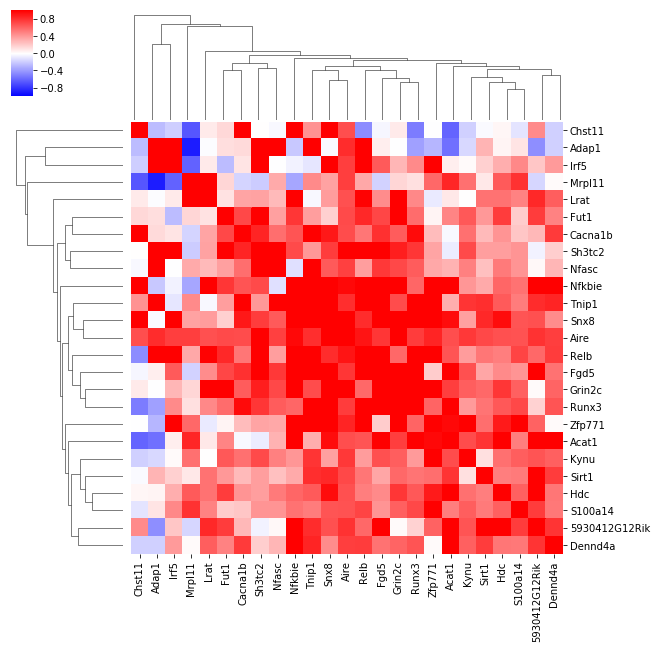

In [174]:
fig, ex = plt.subplots()
fig.set_size_inches(14, 10)
ex=sns.clustermap(top_25_corrected_correlations_raw_CY_TEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)


In [111]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_GW_TEC,min_counts=0.1*raw_GW_TEC.shape[0])
gene_list = np.array(raw_GW_TEC.var_names)

In [112]:
'Aire' in gene_list.tolist()

True

In [113]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_GW_TEC)

## Nc=553, G=8167, Nr=8470.64, Nr_bar=1.04


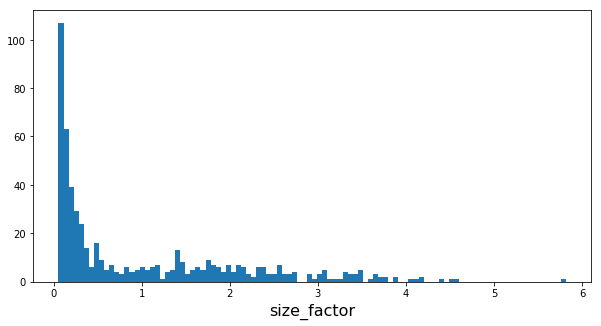

In [114]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_GW_TEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [115]:
M_ml, M_dd = sd.dd_1d_moment(raw_GW_TEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=553, n_gene=8167
#total: 0.06s


In [116]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_GW_TEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_GW_TEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=553, n_gene=8167, Nr=8470.6
#total: 15.12s
#time start: 0.0s
n_cell=553, n_gene=8167, Nr=8470.6
#total: 15.92s


In [118]:
corrected_correlations_raw_GW_TEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [119]:
corrected_correlations_raw_GW_TEC['Aire'].sort_values(ascending=False)

Ctnnal1          1.000000
Nlrc4            1.000000
Tdp1             1.000000
Nmt1             1.000000
Arrb2            1.000000
Stra6            1.000000
Xkr6             1.000000
Ash2l            1.000000
Rab21            1.000000
Gm43255          1.000000
Rgs3             1.000000
Slc22a15         1.000000
Snx8             1.000000
Tnip2            1.000000
Aire             1.000000
Bcl10            0.977703
Cep97            0.977490
Arhgap1          0.954104
Tusc1            0.935838
Marveld2         0.930254
Vps37b           0.919651
Pde1c            0.906740
Gm7967           0.892801
Mum1             0.884063
Polg2            0.876562
D10Jhu81e        0.876335
Tex30            0.870818
Emc8             0.868916
Syne4            0.865387
Gm12688          0.852909
                   ...   
Cdc42bpa        -0.618257
Atraid          -0.618933
Asb13           -0.620682
Il10rb          -0.623438
Tmem189         -0.625591
Mrpl42          -0.626969
Ptov1           -0.641825
Pgp         

In [120]:
top_25_corrected_correlations_raw_GW_TEC = corrected_correlations_raw_GW_TEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_corrected_correlations_raw_GW_TEC_matrix = corrected_correlations_raw_GW_TEC[top_25_corrected_correlations_raw_GW_TEC].loc[top_25_corrected_correlations_raw_GW_TEC]


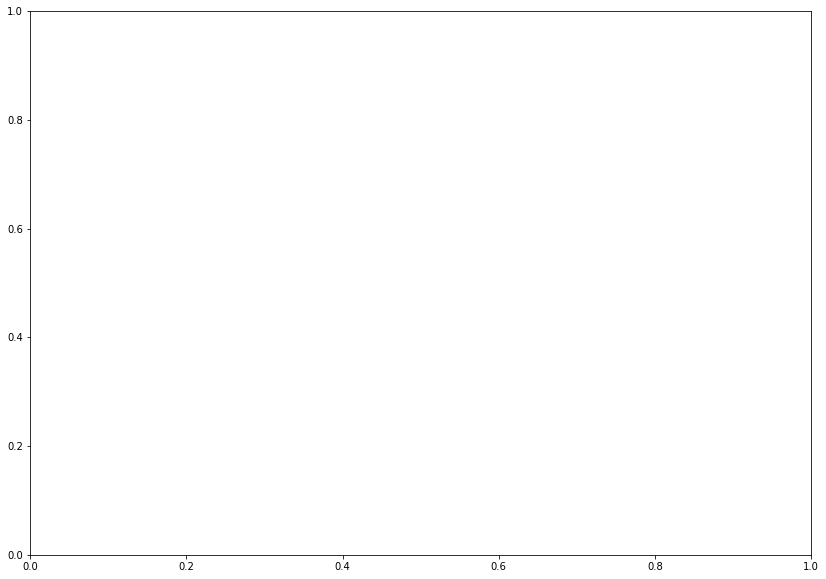

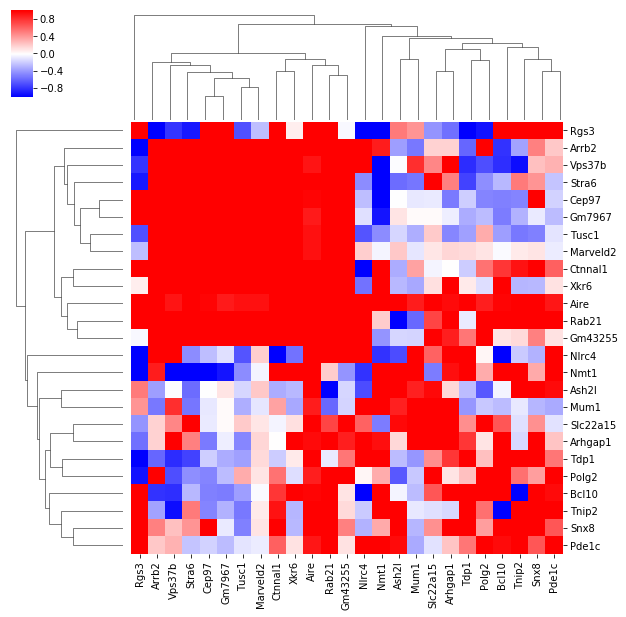

In [175]:

fig, fx = plt.subplots()
fig.set_size_inches(14, 10)
fx=sns.clustermap(top_25_corrected_correlations_raw_GW_TEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)


In [122]:
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(raw_GW_mTEC,min_counts=0.1*raw_GW_mTEC.shape[0])
gene_list = np.array(raw_GW_mTEC.var_names)

In [123]:
'Aire' in gene_list.tolist()

True

In [124]:
Nc,G,Nr,Nr_bar = sd.get_info(raw_GW_mTEC)

## Nc=274, G=7655, Nr=9109.24, Nr_bar=1.19


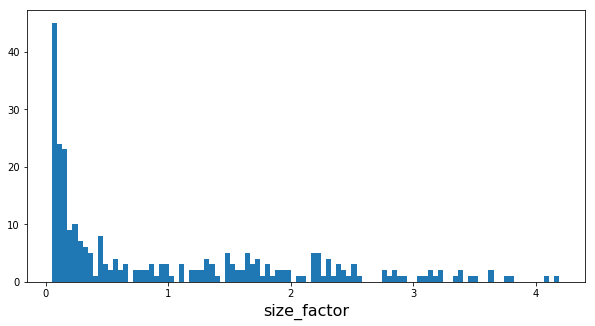

In [125]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(raw_GW_mTEC)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [126]:
M_ml, M_dd = sd.dd_1d_moment(raw_GW_mTEC, size_factor=size_factor)
#cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=274, n_gene=7655
#total: 0.02s


In [127]:
# Estimate PC using plug-in (ml)
#mean_ml,cov_ml,PC_ml  = sd.ml_covariance(raw_GW_mTEC, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(raw_GW_mTEC, size_factor=size_factor,\
                                         PC_prune=True, verbose=True)

#time start: 0.0s
n_cell=274, n_gene=7655, Nr=9109.2
#total: 691.64s
#time start: 0.0s
n_cell=274, n_gene=7655, Nr=9109.2
#total: 18.04s


In [128]:
#need to run, this is for the inaccurate calculation
#uncorrected_correlations_raw_GW_mTEC=pd.DataFrame(PC_ml, index=gene_list.tolist(), columns=gene_list.tolist())

In [129]:
corrected_correlations_raw_GW_mTEC=pd.DataFrame(PC_dd, index=gene_list.tolist(), columns=gene_list.tolist())

In [130]:
corrected_correlations_raw_GW_mTEC['Aire'].sort_values(ascending=False)

Ube2v2           1.000000
Apaf1            1.000000
Ppp1r12a         1.000000
Ino80d           1.000000
Dap              1.000000
Pde4c            1.000000
Hbp1             1.000000
Tmem38a          1.000000
Gm43255          1.000000
Emc8             1.000000
Rgr              1.000000
Atg2a            1.000000
Cnih1            1.000000
Xkr6             1.000000
Nkx2-6           1.000000
2010007H06Rik    1.000000
Rnf111           1.000000
Klhl18           1.000000
Kremen1          1.000000
Plek             1.000000
Gm2000           1.000000
Arrb2            1.000000
Rasal2           1.000000
Gapvd1           1.000000
Strn3            1.000000
Cdc14b           1.000000
Cep97            1.000000
Ap1ar            1.000000
Ppid             1.000000
Marveld2         1.000000
                   ...   
Lap3            -0.802844
Snx7            -0.808549
Nde1            -0.838049
Mycbp           -0.851594
Arpc5l          -0.854332
Mknk1           -0.854446
Sept1           -0.855082
Arpc2       

In [131]:
top_25_corrected_correlations_raw_GW_mTEC = corrected_correlations_raw_GW_mTEC['Aire'].sort_values(ascending = False).index.tolist()[:25]
top_25_corrected_correlations_raw_GW_mTEC_matrix = corrected_correlations_raw_GW_mTEC[top_25_corrected_correlations_raw_GW_mTEC].loc[top_25_corrected_correlations_raw_GW_mTEC]


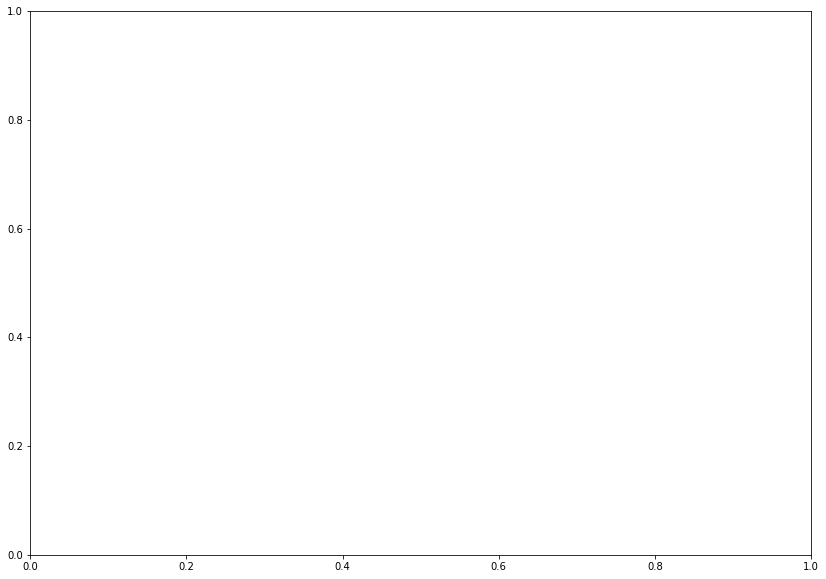

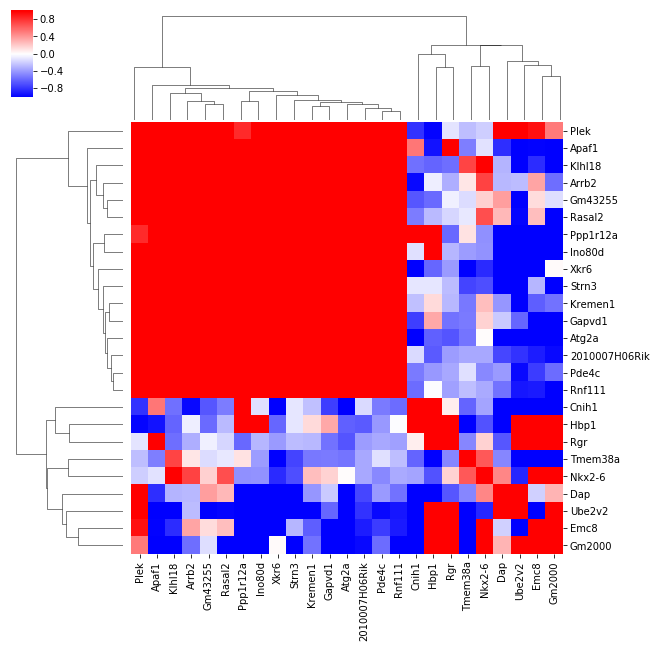

In [176]:
#TSA:Tmem38a, Rgr, Xkr6, Spib
fig, gx = plt.subplots()
fig.set_size_inches(14, 10)
gx=sns.clustermap(top_25_corrected_correlations_raw_GW_mTEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)


In [133]:
top_50_corrected_correlations_raw_GW_mTEC = corrected_correlations_raw_GW_mTEC['Aire'].sort_values(ascending = False).index.tolist()[:50]
top_50_corrected_correlations_raw_GW_mTEC_matrix = corrected_correlations_raw_GW_mTEC[top_50_corrected_correlations_raw_GW_mTEC].loc[top_50_corrected_correlations_raw_GW_mTEC]


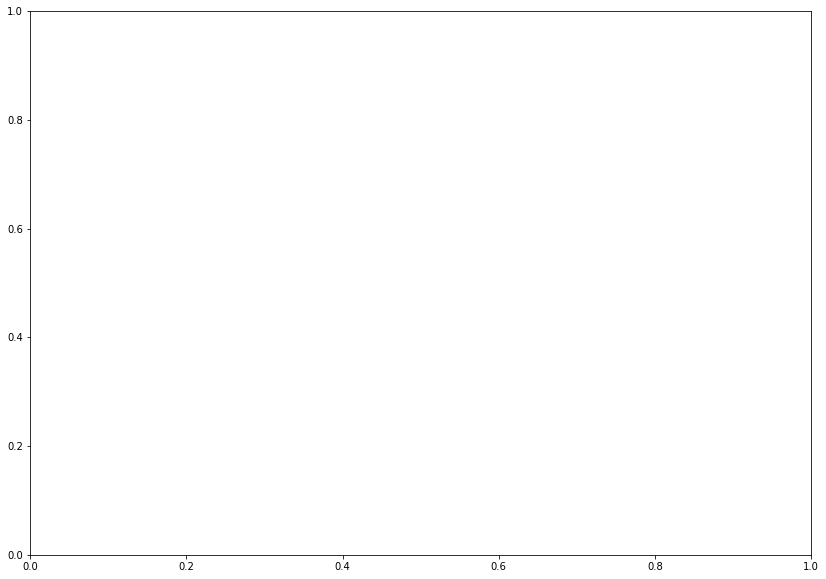

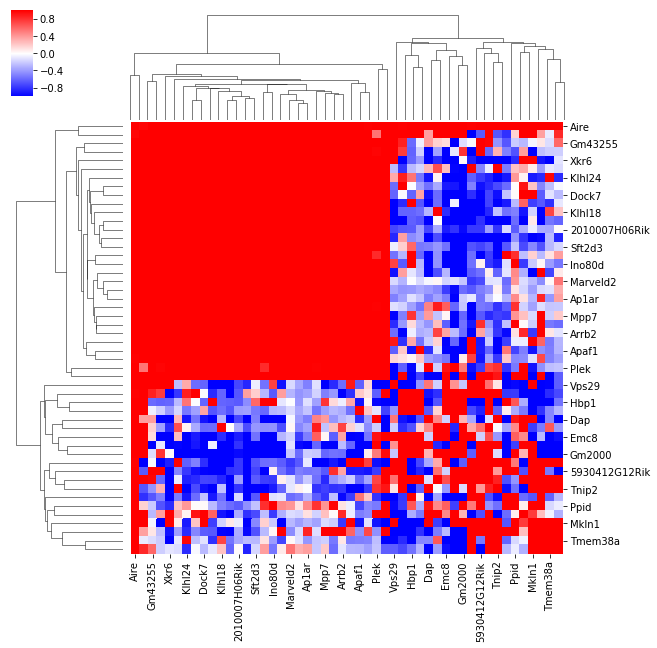

In [177]:
fig, hx = plt.subplots()
fig.set_size_inches(14, 10)
hx=sns.clustermap(top_50_corrected_correlations_raw_GW_mTEC_matrix,cmap='bwr', vmax=1,vmin=-1, center=0, annot=False, square=True)
